## Methodology 
### Turing Study
<insert explanation for Turing study, datasets, and annotations>

In this section, we evaluated each changepoint detection algorithm using the datasets from the Turing study. The code snippets below provide an analysis of an algorithm and it's parameters optimized to find the changepoints closest to the true changepoints and with highest confidence. The purpose of this excercise is to compare the advantages and shortcomings of each algorithm in the KATS package. These insights will be used to determine which algorithm is best suited for Google Mobility data for detecting changepoints during Covid. 

#### Robust Stat Detector
The Robust Stat Detector detects shifts in mean in a time-series. It takes into account a fixed number of points (comparison_window) over which to calculate the mean (smoothing_window_size) and detects changepoints within a given confidence level (p_value_cutoff). 

In [1]:
# List the indices of the true changepoints in the GDP of Japan timeseries from the Turing study

import json 
import pandas as pd 
import numpy as np 
import itertools 

dataset = 'gdp_japan'
annotator_df = pd.read_json('TCPD-master/annotations.json') 
dataset_df = annotator_df[[dataset]] 
list2d = np.array(dataset_df).flatten() 
list2d = [l for l in list2d if (type(l)==list)] 
dataset_annotation_lst = list(itertools.chain.from_iterable(list2d))
dataset_annotation_lst

[32, 32]

True Changepoint at: 1992


<Figure size 960x480 with 0 Axes>

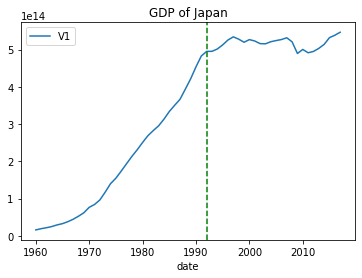

In [2]:
# Plot the timeseries and the true changepoint

import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure 
from load_dataset import TimeSeries 

path = str('TCPD-master/datasets/' + dataset + '/' + dataset + '.json')
ts = TimeSeries.from_json(path)
dataset_df = ts.df
dataset_df['date'] =ts.datestr
#print(dataset_df.dtypes)
column_name = 'V1'
figure(figsize=(12, 6), dpi=80)
dataset_df.plot('date', 'V1')
dataset_df['is_CPD'] = np.where(dataset_df.t.isin(dataset_annotation_lst), 1,0)
plt.axvline(dataset_df.loc[dataset_df['is_CPD']==1][['t']].values[0], color='green', linestyle='--')
plt.title("GDP of Japan")
true_cp = dataset_df.iloc[32]['date']
print("True Changepoint at: " + true_cp )

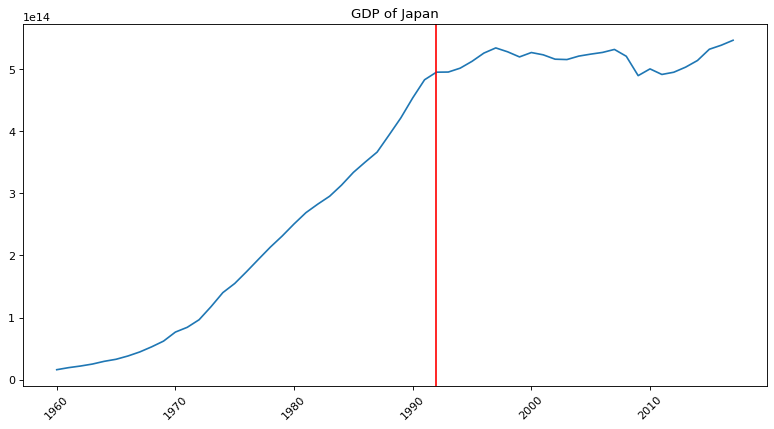

Detected changepoint(s): 


[(TimeSeriesChangePoint(start_time: 1992-01-01T00:00:00.000000000, end_time: 1992-01-01T00:00:00.000000000, confidence: 0.9581645425913177),
  <kats.detectors.robust_stat_detection.RobustStatMetadata at 0x7ff363ccfa90>)]

In [3]:
# Detect changepoints in the GDP of Japan timeseries with at least 95% confidence with Robust Stat Detector algorithm

from kats.detectors.robust_stat_detection import RobustStatDetector
from kats.consts import TimeSeriesData

df = dataset_df
df['time']= pd.to_datetime(df['date'])
tsd = TimeSeriesData(df.loc[:,['time', column_name]])
detector = RobustStatDetector(tsd)
change_points = detector.detector(comparison_window=5, smoothing_window_size=5, p_value_cutoff=0.05)
figure(figsize=(12, 6), dpi=80)
plt.xticks(rotation=45)
plt.title("GDP of Japan")
detector.plot(change_points)
print("Detected changepoint(s): ")
change_points

In [4]:
# Tune hyperparameters: comparison_window and smoothing_window_size

# Parse list of changepoints and confidence
def parse_CPs(changepoints):    
    cp_list = []
    for cp in changepoints:
        changepoint = str(cp[0])[34:38]
        confidence = str(cp[0])[119:125]
        cp_list.append(changepoint)
    return cp_list

# Hyperparameter tuning for RSD algo
def hp_tuning_RSD(df):

    # Initialize the detector
    detector = RobustStatDetector(tsd)

    hp_list = []
    #hp_result['true_CP_detected'] = []
    comparison_window = 0
    smoothing_window_size = 0
    p_value_cutoff = 0.05
    hp_value = {}
    for i in range(1,20):
        for j in range(1, 20):
            #for k in range(1, 10):
                #threshold = k*0.1
            smoothing_window_size = i
            comparison_window = j
            change_points = detector.detector(
                comparison_window=comparison_window,
                smoothing_window_size=smoothing_window_size,
                p_value_cutoff=0.05
            )
            hp_value = {'comparison_window': comparison_window, 'smoothing_window': smoothing_window_size, 'CP': parse_CPs(change_points)}
            hp_list.append(hp_value)
    return pd.DataFrame(hp_list)

In [5]:
# Run the hyperparameter tuning methods and export the results to a .csv file

dataset_hp_rsd = hp_tuning_RSD(tsd)
dataset_hp_rsd.to_csv("gdp_japan_hp_rsd.csv")

In [6]:
# Plot the results of hyperparameter tuning

import hiplot as hip

cp_hiplot = hip.Experiment.from_csv('gdp_japan_hp_rsd.csv')
cp_hiplot.display()

<IPython.core.display.Javascript object>

The true changepoint, '1992', is only detected when the comparison_window or smoothing_size_window ranges from 2-8 or is at the value of 19. Interestingly, the valid range for both parameters is the same and either one should be within the valid range to detect the true changepoint. 

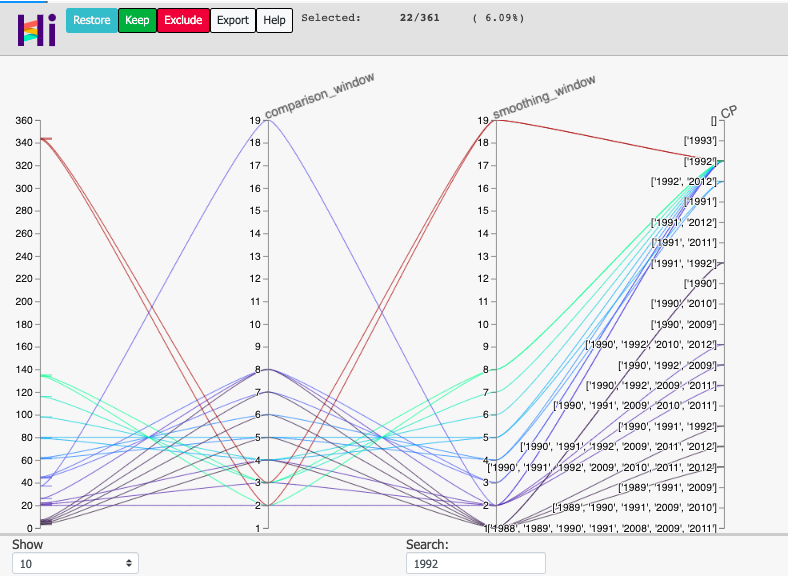